# The story behind the code
Below you will find my solution to the kind of problem which is asked when you applied to the famous shoes company. They ask the same problem for at least two years and usually don' give you any feedback about your solution.

First I remind the problem as it is presented and then I propose my solution.

## Odnaza 's next top Analyst

The Zolonda Data Intelligence Team is searching for a new top analyst. We already know of an excellent candidate with top analytical and programming skills. Unfortunately, we don't know her exact whereabouts but we only have some vague information where she might be. Can you tell us where to best send our recruiters and plot an easy to read map of your solution for them?

This is what we could extract from independent sources:

- The candidate is likely to be close to the river Spree. The probability at any point is given by a Gaussian function of its shortest distance to the river. The function peaks at zero and has 95% of its total integral within +/-2730m
- A probability distribution centered around the Brandenburg Gate also informs us of the candidate's location. The distribution’s radial profile is log-normal with a mean of 4700m and a mode of 3877m in every direction.
- A satellite offers further information: with 95% probability she is located within 2400 m distance of the satellite’s path (assuming a normal probability distribution)

### Tip for conversion of coordinates
You can (but don’t have to) use following simple projection for getting GPS coordinates into an orthogonal coordinate system.

The projection is reasonably accurate for the Berlin area.

Result is an XY coordinate system with the origin (0,0) at the South-West corner of the area we are interested in. 
- The X axis corresponds to East-West and is given in kilometres. 
- The Y axis corresponds to North-South and is also given in kilometres.

### Format of your result

Please provide the GPS coordinates of the next Top Analyst as part of your application. 

In addition, you can send us your code and some visualizations.


In [1]:
#
# Here we do some initialization
#
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import Circle, Rectangle
%matplotlib inline
from scipy.stats import lognorm
from scipy.stats import vonmises

# Coordinates
# Earth_radius
earth_radius = 6371 # in km

#Brandenburg Gate GPS coordinates
brandenbourg_gate_gps = [(52.516288,13.377689)]

# Satellite path is a great circle path between coordinates
satellite_path_door_gps = [(52.590117,13.39915),(52.437385,13.553989)]

#River Spree can be approximated as piecewise linear between the following coordinates:
river_spree_gps = [(52.529198,13.274099),
(52.531835,13.29234), (52.522116,13.298541), (52.520569,13.317349), (52.524877,13.322434),
(52.522788,13.329), (52.517056,13.332075), (52.522514,13.340743), (52.517239,13.356665),
(52.523063,13.372158), (52.519198,13.379453), (52.522462,13.392328), (52.520921,13.399703),
(52.515333,13.406054), (52.514863,13.416354), (52.506034,13.435923), (52.496473,13.461587),
(52.487641,13.483216), (52.488739,13.491456), (52.464011,13.503386)]

# South-west corner of the area we are interested in:
SW_lat = 52.464011 #(Latitude)
SW_lon = 13.274099 #(Longitude)
south_west_corner_gps = [(SW_lat, SW_lon)]

# Parameters for the search window
max_width = 18
max_height = 8

Below I display the shape of variables because I like to do so.

In [2]:
print np.shape(brandenbourg_gate_gps)
print np.shape(satellite_path_door_gps)
print np.shape(river_spree_gps)

(1, 2)
(2, 2)
(20, 2)


In [3]:
#
# Here we do some functions initialization
#

# The x and y coordinates of a GPS coordinate P with (P_lat, P_lon) can be calculated using:
def fun_convert_gps_to_xy(coord_gps, ref_point_gps):
    """The function does what it should do.
    It takes gps coord as input
    """
    P_lat = coord_gps[0][0]
    P_lon = coord_gps[0][1]
    SW_lat = ref_point_gps[0][0]
    SW_lon = ref_point_gps[0][1]
    P_x = (P_lon - SW_lon) * np.cos(SW_lat * np.pi / 180) * 111.323
    P_y = (P_lat - SW_lat) * 111.323
    coord_xy = (P_x, P_y)
    return coord_xy

def fun_convert_XY_to_gps(ref_gps, dest_xy, earth_radius):
    """Assuming a small displacement
    lat = lat0 + (180/pi)*(dy/6378137)
    lon = lon0 + (180/pi)*(dx/6378137)/cos(lat0)
    I also assume that my starting point is the south_west_corner.
    """ 
    ref_xy = [0,0]
    dx, dy = dest_xy[0], dest_xy[1]
    
    target_gps_lat = ref_gps[0][0] + (180 / np.pi) * (dy / earth_radius)
    target_gps_lon = ref_gps[0][1] + (180 / np.pi) * (dx / earth_radius) / np.cos(np.pi/180*ref_gps[0][0])
    
    target_gps =  [(target_gps_lat, target_gps_lon)]
    
    return target_gps

def fun_get_line_equation_from_vecs(pA, pB):
    """From two points get the line equation y= ax+b
    assuming pA = [xA, yA]
    and      pB = [xB, yB]
    """
    a = (pA[1] - pB[1]) / (pA[0] - pB[0])
    b = (pB[0] * pA[1] - pA[0] * pB[1]) / (pB[0] - pA[0])
    return a, b

def fun_get_dist_point_to_line(a, b, pG):
    """The function does what it should do.
    Where y = ax+b and pG = [xG, yG]
    """
    dd = np.abs(pG[0]*a - pG[1] + b) / np.sqrt(1 + a * a)
    return dd

def fun_rotate_vector(pA, angle_value):
    """here we rotate a vector pA = [dx, dy] by an angle of value angle_value"""
    pR = np.zeros(np.shape(pA))
    pR[0] = pA[0] * np.cos(angle_value) - pA[1] * np.sin(angle_value)
    pR[1] = pA[0] * np.sin(angle_value) + pA[1] * np.cos(angle_value)
    #print "(%1.2f, %1.2f)" % (pA[0], pA[1])
    #print "(%1.2f, %1.2f)" % (pR[0], pR[1])
    #print "(%1.2f)" % (pA[0] * pR[0] + pA[1] * pR[1])
    return pR


## Time for some calculation
Below we do all the conversion from gps coordinates to XY.

In [4]:
print 'brandendbourg gate'
brandenbourg_gate_xy = fun_convert_gps_to_xy(brandenbourg_gate_gps, south_west_corner_gps)
print 'coord X: %1.6f and coord Y: %1.6f' % (brandenbourg_gate_xy[0], brandenbourg_gate_xy[1])

print 'south west corner'
south_west_corner_xy = fun_convert_gps_to_xy(south_west_corner_gps, south_west_corner_gps)
print 'coord X: %1.6f and coord Y: %1.6f' % (south_west_corner_xy[0], south_west_corner_xy[1])

print 'satellite door'
satellite_path_door_xy = np.zeros((2,2))
i = 0
for coords in satellite_path_door_gps:
    xy = [(coords[0], coords[1])]
    #print xy
    satellite_path_door_xy[i,:] = fun_convert_gps_to_xy(xy, south_west_corner_gps)
    #print 'coord X: %1.6f and coord Y: %1.6f' % (satellite_path_door_xy[i,0], satellite_path_door_xy[i,1])
    i = i + 1

# center of the door
satellite_door_x = (satellite_path_door_xy[1,0] - satellite_path_door_xy[0,0]) / 2 + satellite_path_door_xy[0,0]
satellite_door_y = (satellite_path_door_xy[1,1] - satellite_path_door_xy[0,1]) / 2 + satellite_path_door_xy[0,1]

print 'spree'
river_spree_xy = np.zeros((20,2))
i = 0
for coord in river_spree_gps:
    #print coord, np.shape(coord)
    xy = [(coord[0], coord[1])]
    river_spree_xy[i,:] = fun_convert_gps_to_xy(xy, south_west_corner_gps)
    #print 'coord X: %1.6f and coord Y: %1.6f' % (river_spree_xy[i,0], river_spree_xy[i,1])
    i = i + 1
    
# Some more parameters
pR = fun_rotate_vector([satellite_path_door_xy[0,0] - satellite_path_door_xy[1,0],
                            satellite_path_door_xy[0,1] - satellite_path_door_xy[1,1]], np.pi / 2)

# Here we get the line parameters for the satellite path
aa, bb  = fun_get_line_equation_from_vecs([satellite_door_x, satellite_door_y],
                                          [satellite_door_x + pR[0] , satellite_door_y + pR[1]])


brandendbourg gate
coord X: 7.025951 and coord Y: 5.819632
south west corner
coord X: 0.000000 and coord Y: 0.000000
satellite door
spree


## Doing some basic visualization
Before jumping into formulas we display the various points and probability distributions describing the problem.

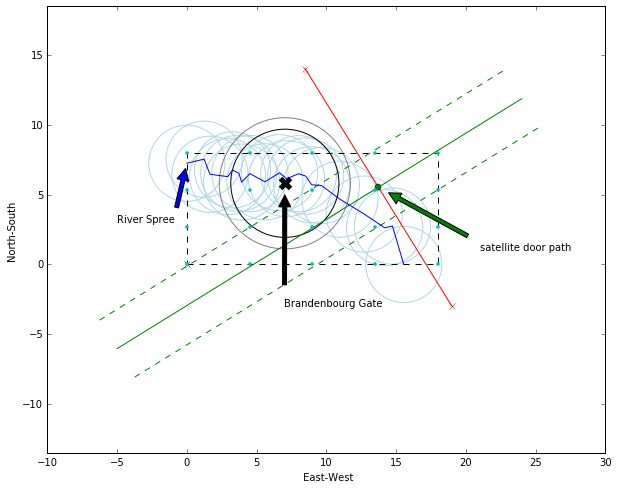

In [5]:
def fun_display_scene_problem():
    fig = plt.figure(figsize=(10,8))
    ax = fig.add_subplot(111)

    # plot the brandenbourg gate
    plt.plot(brandenbourg_gate_xy[0], brandenbourg_gate_xy[1], 'x', markeredgewidth = 5, markersize = 10, color = 'black')
    plt.annotate('Brandenbourg Gate', xy=(brandenbourg_gate_xy[0], brandenbourg_gate_xy[1]), 
                                      xytext=(7, -3),arrowprops=dict(facecolor='black', shrink=0.1),)

    # plot the south west corner
    plt.plot(south_west_corner_xy[0], south_west_corner_xy[1], 'x',  color = 'black')

    # plot the satellite path
    plt.plot(satellite_path_door_xy[:,0], satellite_path_door_xy[:,1],'-', color ='red')
    plt.plot(satellite_path_door_xy[0,0], satellite_path_door_xy[0,1],'x', color ='red')
    plt.plot(satellite_path_door_xy[1,0], satellite_path_door_xy[1,1],'x', color ='red')
    plt.plot(satellite_door_x, satellite_door_y,'o', color = 'green')
    plt.annotate('satellite door path', xy=(satellite_door_x, satellite_door_y),
                              xytext=(21,1),
                              arrowprops=dict(facecolor='green', shrink=0.1),)

    # equation of the path is y = ax + b
    # I need to computer the line equation orthogonal to the line defined by the 
    # the satellit "door" and going by the center of these two coordinates
    # vector of the "door path" is
    vec_door_path_x = satellite_path_door_xy[1,0] - satellite_path_door_xy[0,0]
    vec_door_path_y = satellite_path_door_xy[1,1] - satellite_path_door_xy[0,1]

    norm_vec = np.linalg.norm([vec_door_path_x, vec_door_path_y])
    #plt.plot([satellite_door_x, satellite_door_x+ vec_door_path_x / 4],
    #          [satellite_door_y, satellite_door_y+ vec_door_path_y / 4],color = 'green')

    pR = fun_rotate_vector([satellite_path_door_xy[0,0] - satellite_path_door_xy[1,0],
                            satellite_path_door_xy[0,1] - satellite_path_door_xy[1,1]], np.pi / 2)

    # Here we get the line parameters for the satellite path
    aa, bb  = fun_get_line_equation_from_vecs([satellite_door_x, satellite_door_y],
                                              [satellite_door_x + pR[0] , satellite_door_y + pR[1]])

    # create a set of point to display the satellite path 
    x = np.arange(-5,25,1)
    yy = aa * x + bb
    plt.plot(x, yy, '-', color = 'g')
    dir_vec  = ([satellite_path_door_xy[0,0] - satellite_path_door_xy[1,0],
                 satellite_path_door_xy[0,1] - satellite_path_door_xy[1,1]])
    norm_vec = np.linalg.norm(dir_vec)
    #print dir_vec
    #print norm_vec
    dX = dir_vec[0] / norm_vec * 2.4
    dY = dir_vec[1] / norm_vec * 2.4
    plt.plot(x + dX, yy + dY, '--', color = 'g')
    plt.plot(x - dX, yy - dY, '--', color = 'g')

    # plot the Spree
    plt.plot(river_spree_xy[:,0],river_spree_xy[:,1],'-', color = 'blue')
    plt.annotate('River Spree', xy=(river_spree_xy[0,0], river_spree_xy[0,1]), 
                                      xytext=(-5,3),arrowprops=dict(facecolor='blue', shrink=0.1),)

    for i in np.arange(0,np.shape(river_spree_xy)[0]):
        circleS = Circle((river_spree_xy[i,0],river_spree_xy[i,1]), 2.73, fc='none',ec="lightblue")
        plt.gca().add_patch(circleS)
        i = i +1

    plt.axis('equal')
    plt.xlabel(' East-West')
    plt.ylabel('North-South')

    # plot probability of presence around brandenbourg gate
    circle1 = Circle(brandenbourg_gate_xy, 4.7, fc='none',ec="gray")
    plt.gca().add_patch(circle1)
    circle2 = Circle(brandenbourg_gate_xy, 3.877, fc='none',ec="black")
    plt.gca().add_patch(circle2)
    rectangle = Rectangle(south_west_corner_xy, max_width, max_height, fc='none',ec='black', linestyle='dashed')
    plt.gca().add_patch(rectangle)

#
# Now we display the scene
#
fun_display_scene_problem()
# plot test points
xv, yv = np.meshgrid(np.linspace(0, max_width, 5), np.linspace(0, max_height, 4))
xv = xv[:]
yv = yv[:]
plt.plot(xv, yv, '.c')
plt.draw()
plt.savefig('sceneWithoutTopAnalystLocation.png')
plt.show()

## Now we compute the location
For every points in the rectangle with dashed border we compute the probability value for next Top Analyste search to be there.

Below more functions to compute the various probability functions.

Each function follows the same approach:
- compute the distance from a grid point to the center of a pdf (or line)
- use the distance with the pdf to get a probability value

Then process all this information to give the gps coordinates. Actually it gives first the XY coordinates and it needs to be converted back to gps.

I could probably have formulated thhis problem as more elegant optimization/ML form, but this fast approach works - I hope - and give me something that looks reasonnable.

In [6]:
def fun_brandenbourg_gate(grid_xy, ref_corner_gps, ref_gps):
    """A probability distribution centered around the Brandenburg Gate also informs us of 
    the candidate's location. The distribution’s radial profile is log-normal with a mean
    of 4700m and a mode of 3877m in every direction"""
    
    brandenbourg_gate_xy = fun_convert_gps_to_xy(ref_gps, ref_corner_gps)
    
    # compute distance point to the center
    dd = np.zeros((np.shape(grid_xy)[0],1))
    pv = np.zeros((np.shape(grid_xy)[0],1))
    for i in np.arange(0,np.shape(grid_xy)[0]):
        dd[i,0] =  np.sqrt(np.sum((grid_xy[i,:] - brandenbourg_gate_xy)**2))
    
    # compute the probability
    meanlog = 4.7 
    sdlog = 3.877
    for i in np.arange(0,np.shape(grid_xy)[0]):
        pv[i,0] = lognorm.pdf(dd[i,0], sdlog, 0, np.exp(meanlog))
        
    #
    # if the distance is bigger than the shape of the pdf then set to 0
    #
    
    return dd, pv

def fun_river_spree(grid_xy, ref_corner_gps, ref_gps):
    """The candidate is likely to be close to the river Spree. The probability at any point
    is given by a Gaussian function of its shortest distance to the river. The function peaks 
    at zero and has 95% of its total integral within +/-2730m
    
    It is similar as for the brandenbourg gate case, just the shape of the pdf changes.
    """
    i = 0
    for coord in river_spree_gps:
        xy = [(coord[0], coord[1])]
        river_spree_xy[i,:] = fun_convert_gps_to_xy(xy, ref_corner_gps)
        i = i + 1
    
    # for each point of the river Spree I compute the distance, then apply the pdf
    dd = np.zeros((np.shape(grid_xy)[0],np.shape(river_spree_xy)[0]))
    pv = np.zeros((np.shape(grid_xy)[0],np.shape(river_spree_xy)[0]))
    for i in np.arange(0,np.shape(grid_xy)[0]):
        for j in np.arange(0,np.shape(river_spree_xy)[0]):
            dd[i,j] =  np.sqrt(np.sum((grid_xy[i,:] - river_spree_xy[j,:])**2))
    
    std = 2.73
    for i in np.arange(0,np.shape(grid_xy)[0]):
        for j in np.arange(0,np.shape(river_spree_xy)[0]):  
            pv[i,j] = ( 1 / std * np.sqrt(2*np.pi) ) * np.exp(-(dd[i,j]**2 / (2 * std**2)))
        
    
    return dd, pv
            
def fun_satellite(grid_xy, a, b):
    """A satellite offers further information: with 95% probability she is located within 2400 m 
    distance of the satellite’s path (assuming a normal probability distribution)
    """
    # compute for each point of the grid the distance to the satellite path
    dd = np.zeros((np.shape(grid_xy)[0],1))
    pv = np.zeros((np.shape(grid_xy)[0],1))
    for i in np.arange(0,np.shape(grid_xy)[0]):
        pG = [grid_xy[i,0], grid_xy[i,1]]
        dd[i,0] = fun_get_dist_point_to_line(a, b, pG)
    
    # compute the probability
    std = 2.4
    for i in np.arange(0,np.shape(grid_xy)[0]):
        pv[i,0] = ( 1 / std * np.sqrt(2*np.pi) ) * np.exp(-(dd[i,0]**2 / (2 * std**2)))
    
    return dd, pv
    
def fun_process_all_distribution(grid_xy, bg_pv, rs_pv, sa_pv):
    """Where 
    bg_pv is for the brandenbourg gate pdf
    rs_pv is for the river spree pdf
    sa_pv is for of the satellite pdf
    
    We assume the same weight for each pdf
    """

    res = np.zeros((np.shape(rs_pv)))
    print np.shape(res)
    for i in np.arange(0,np.shape(grid_xy)[0]):
        for j in np.arange(0,np.shape(rs_pv)[1]):
            res[i,j] = (bg_pv[i] + rs_pv[i,j] + sa_pv[i]) / 3 
    
    # store the best results per Spree point
    final_res = np.zeros((20, 3))
    for j in np.arange(0, np.shape(res)[1]): 
        max_ind = np.argmax(res[:,j])
        final_res[j,0] = grid_xy[max_ind, 0]
        final_res[j,1] = grid_xy[max_ind, 1]
        final_res[j,2] = res[max_ind, j]
    
    # store the best of the best among the Spree points
    final_max_ind = np.argmax(final_res[:,2])
    final_max_res = []
    final_max_res.append(final_res[final_max_ind,0])
    final_max_res.append(final_res[final_max_ind,1])
    final_max_res.append(final_res[final_max_ind,2])
    return res, final_res, final_max_res
 

In [7]:
#   
# Now compute distances and pb
#

min_width  = 10 
min_height = 3
max_width  = 14
max_height = 5

#
# the variables below define the procision you want to achieve
#
nb_step_x = 0.025
nb_step_y = 0.025
xv, yv  = np.meshgrid(np.hstack([np.arange(min_width,max_width, nb_step_x), max_width]),#linspace(0, 20, nb_step_x), 
                      np.hstack([np.arange(min_height,max_height, nb_step_y), max_height]))#np.linspace(0, 15, nb_step_y))
grid_xy = np.rot90(np.vstack([xv.flatten(), yv.flatten()]))

dd_river_spree, pv_river_spree = fun_river_spree(grid_xy, south_west_corner_gps, river_spree_gps)
dd_brandenbourg_gate, pv_brandenbourg_gate = fun_brandenbourg_gate(grid_xy, south_west_corner_gps, brandenbourg_gate_gps)
dd_satellite, pv_satellite = fun_satellite(grid_xy, aa, bb)

# Now we combine all pdf
res, final_res, final_max_res = fun_process_all_distribution(grid_xy, pv_brandenbourg_gate, pv_river_spree, pv_satellite)


(13041, 20)


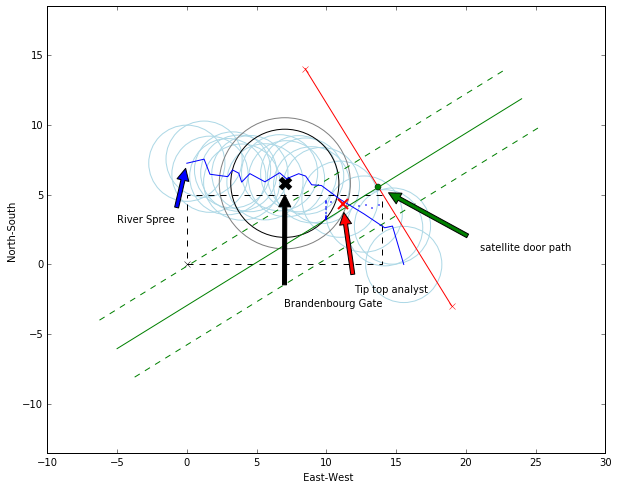

The top analyst is in position X: 11.18 Y:4.30


In [8]:
#
# Dispaly final results
#
fun_display_scene_problem()
for j in np.arange(0, np.shape(res)[1]):    
    plt.plot(grid_xy[np.argmax(res[:,j]),0], grid_xy[np.argmax(res[:,j]),1], '.',color = 'blue', markersize = 2)
plt.plot(final_max_res[0], final_max_res[1],'x', color = 'red', markeredgewidth = 2, markersize = 10)

plt.annotate('Tip top analyst', xy=(final_max_res[0], final_max_res[1]), 
                                      xytext=(12, -2),arrowprops=dict(facecolor='red', shrink=0.1),)

plt.draw()
plt.savefig('sceneAndTopAnalystLocation.png')
plt.show()


print "The top analyst is in position X: %1.2f Y:%1.2f" % (final_max_res[0], final_max_res[1])

In [9]:
X, Y = final_max_res[0], final_max_res[1]
 
top_gps = fun_convert_XY_to_gps(south_west_corner_gps, [X,Y], earth_radius)
print top_gps
print fun_convert_gps_to_xy(top_gps, south_west_corner_gps)

[(52.502681829054502, 13.439051975150305)]
(11.187871268413444, 4.3049527028344405)
